### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score

#Extra libraries
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression,mutual_info_regression
from sklearn.feature_selection import SelectKBest
import xgboost as xgb

%matplotlib inline
sns.set_style("darkgrid")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

print(os.listdir('../input/engraulis-encrasicolus-prediction/'))

['sample_submission.csv', 'train.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/engraulis-encrasicolus-prediction/train.csv')
test = pd.read_csv('../input/engraulis-encrasicolus-prediction/test.csv')
print("Train has {} samples and {} variables.".format(train.shape[0],train.shape[1]))
print("Test has {} samples and {} variables.".format(test.shape[0],test.shape[1]))

Train has 527 samples and 6831 variables.
Test has 202 samples and 6830 variables.


# Plotting Some Of the Data

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


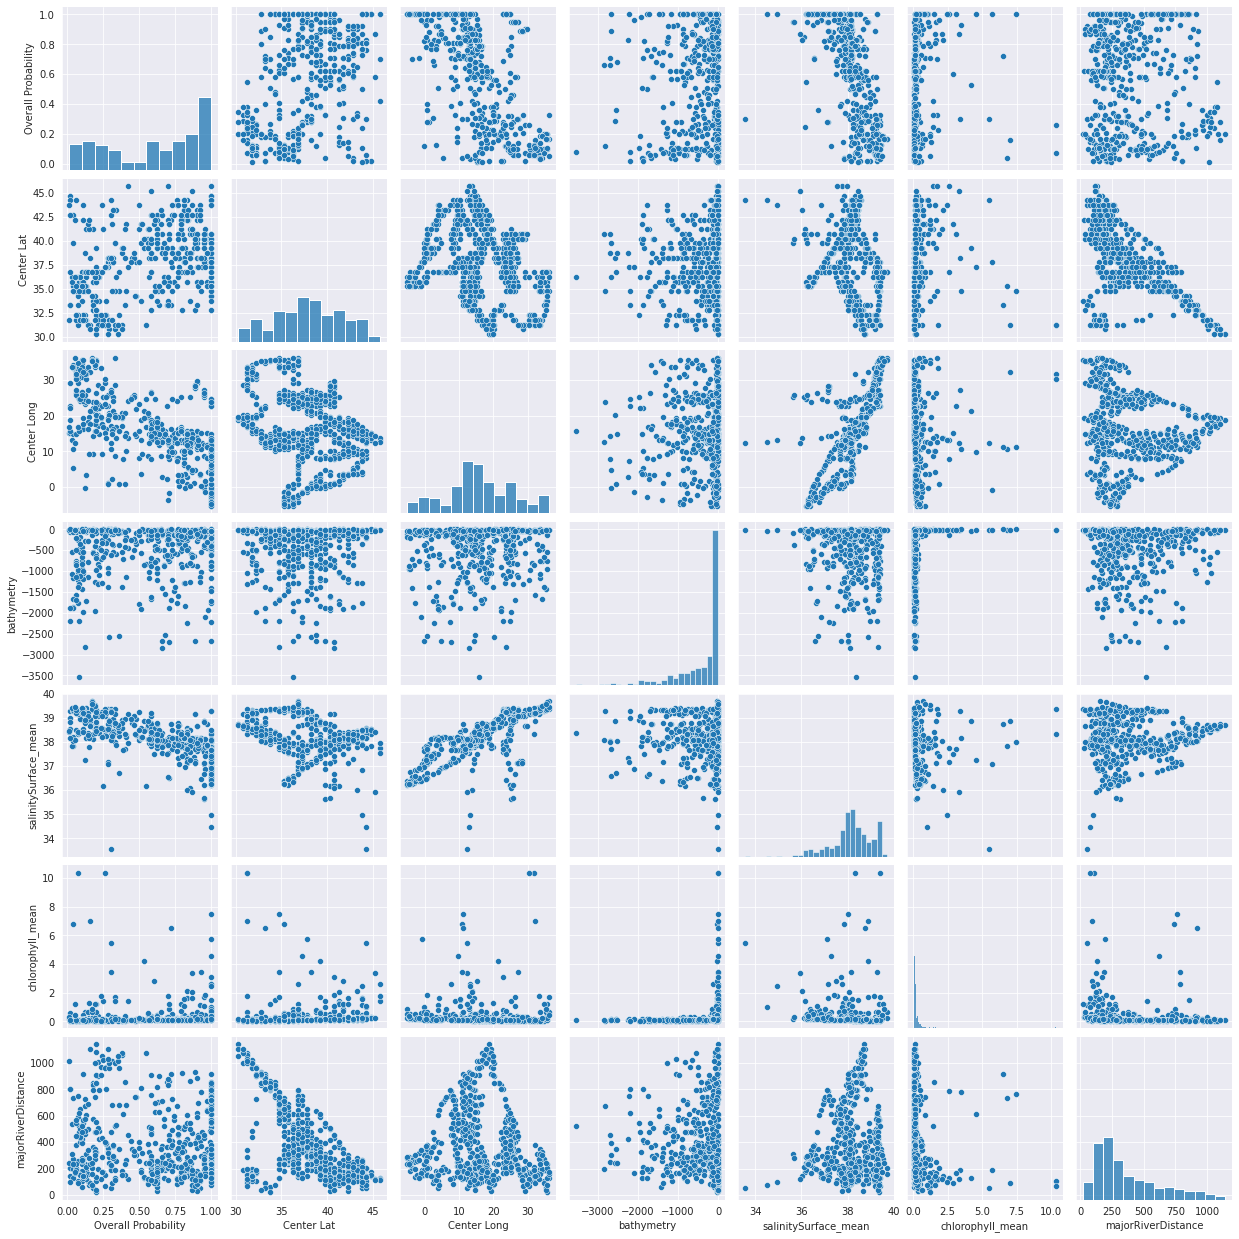

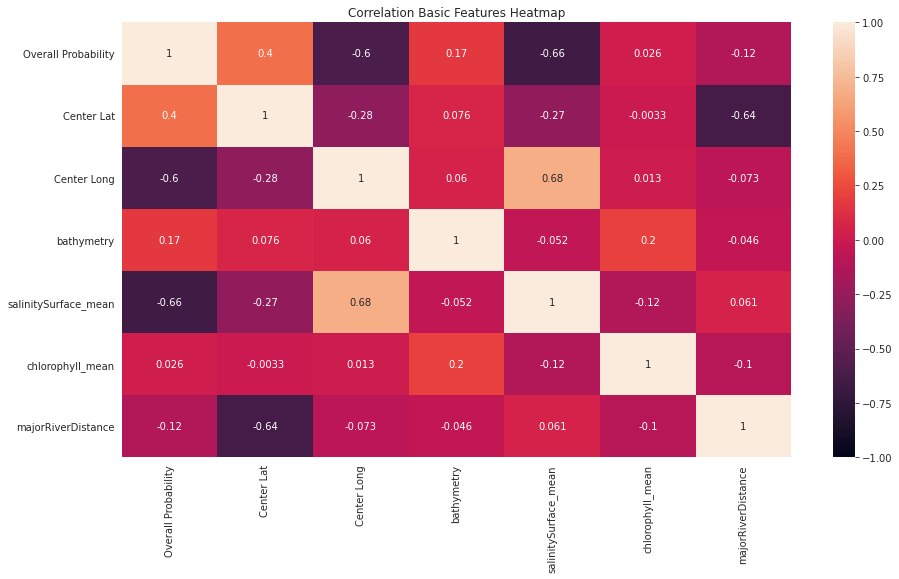

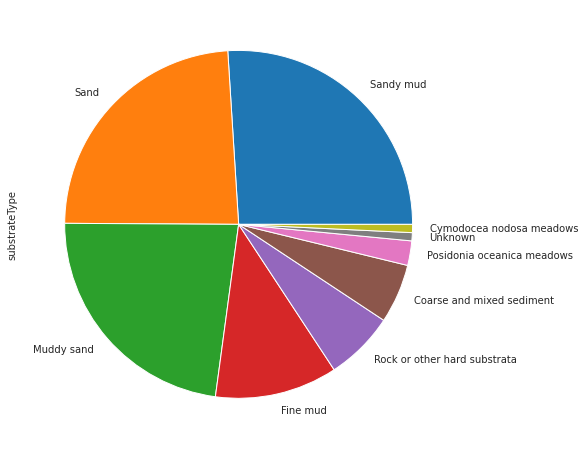

<Figure size 1080x864 with 0 Axes>

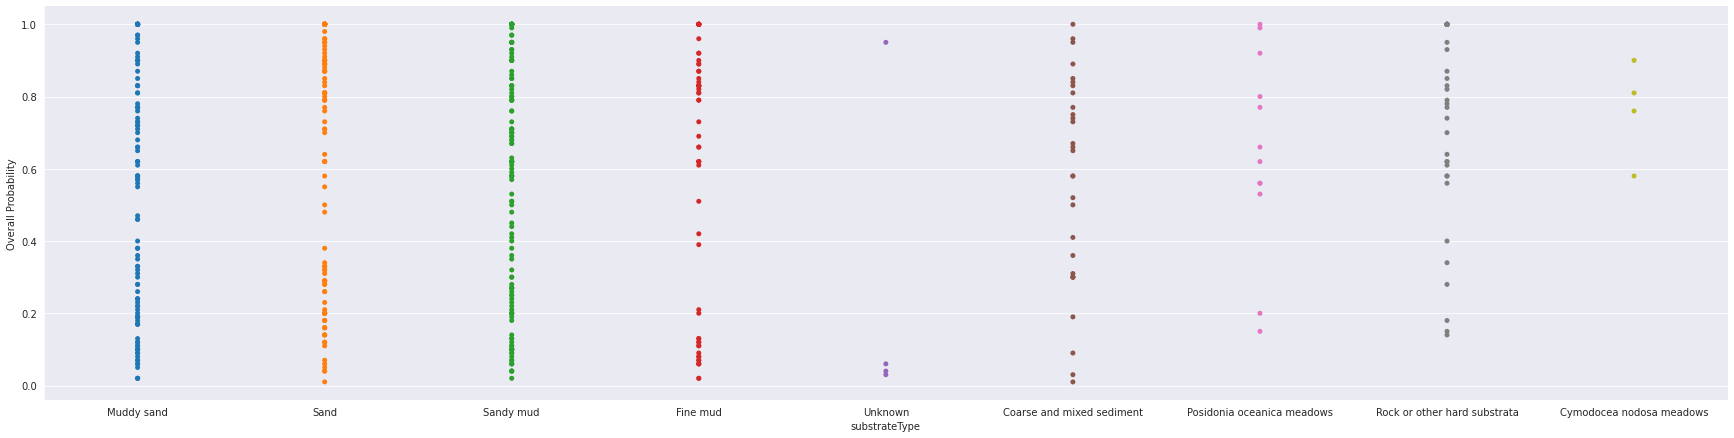

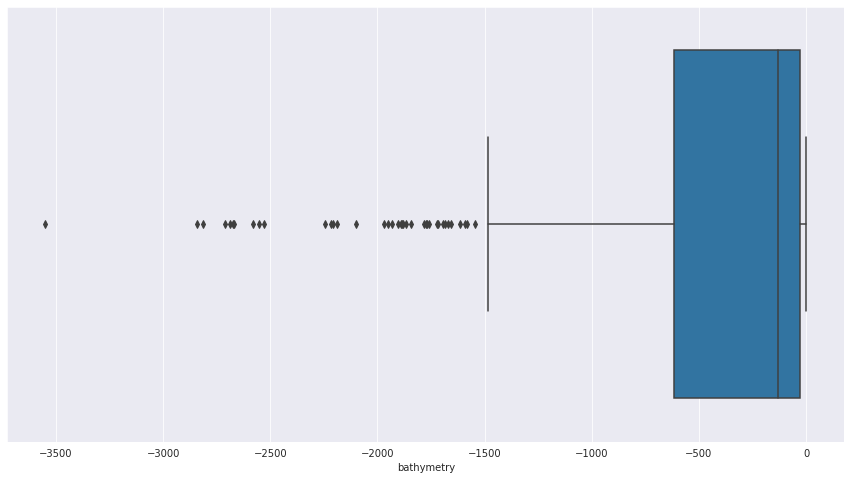

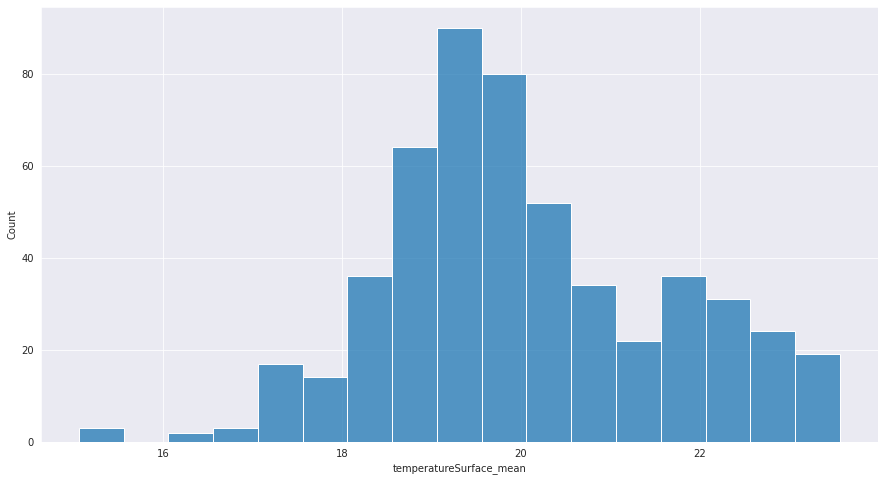

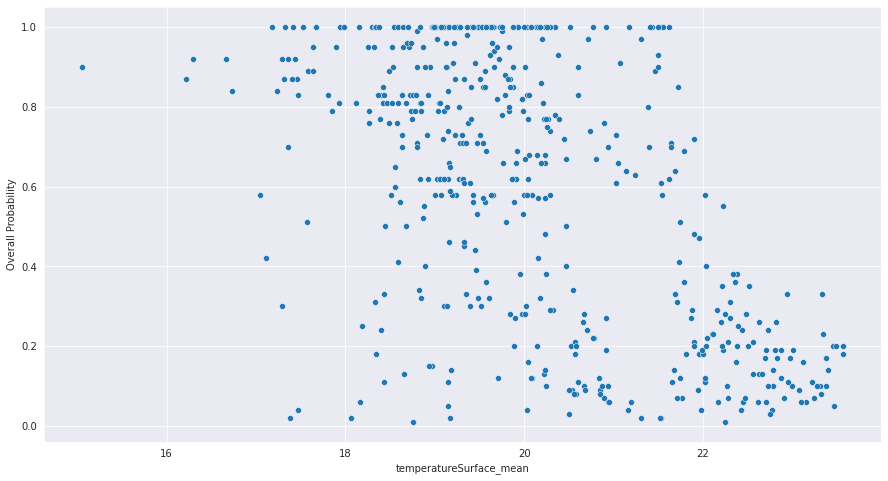

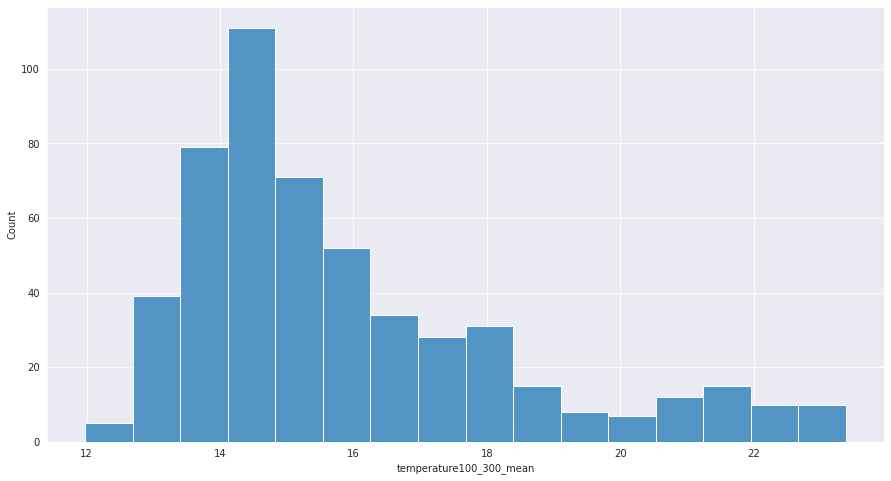

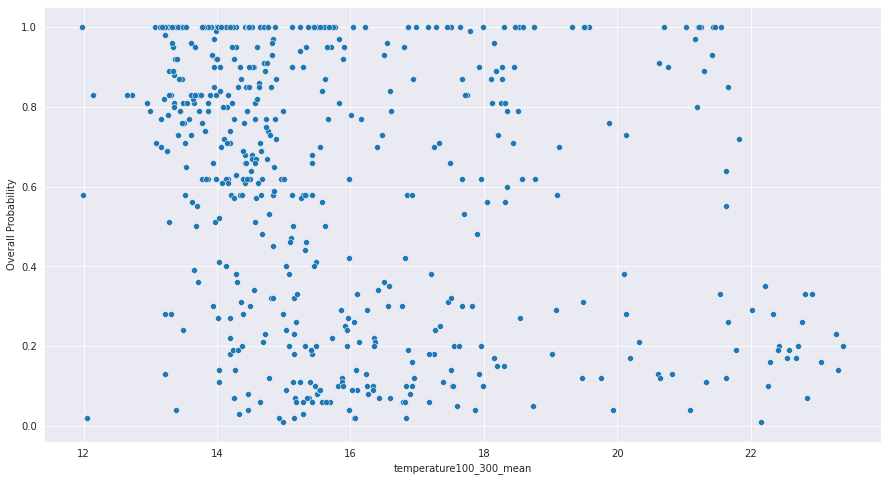

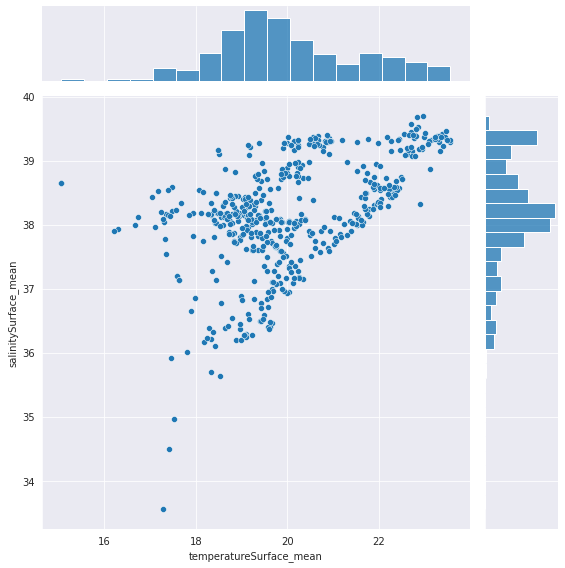

In [3]:
columns_to_plot = ["Overall Probability","Center Lat","Center Long","bathymetry","salinitySurface_mean","chlorophyll_mean","majorRiverDistance"]
#Pair Plot Basic Features of Species
sns.pairplot(train[columns_to_plot])
#Heatmap Correlation of Basic Features of the Species
correlation_to_plot = train[columns_to_plot].corr()
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(correlation_to_plot,annot=True,vmin=-1,vmax=1)
heatmap.set_title("Correlation Basic Features Heatmap")
#Pie Chart of substrateType
plt.figure(figsize=(15,8))
train['substrateType'].value_counts().plot(kind='pie',subplots=True)

#Catplot of substrateType with Overall Probability
plt.figure(figsize=(15,12))
sns.catplot(x="substrateType", y="Overall Probability", jitter=False, data=train,height=6,aspect = 4)

#Boxplot of Bathymetry (used as an example for outliers)
plt.figure(figsize=(15,8))
col_for_box=[x for x in columns_to_plot if x!='Overall Probability']
sns.boxplot(data=train,x='bathymetry')

#Scatterplot and histplot of temperature Features (only two)
plt.figure(figsize=(15,8))
sns.histplot(data=train,x="temperatureSurface_mean")
plt.figure(figsize=(15,8))
sns.scatterplot(data=train,x="temperatureSurface_mean",y="Overall Probability")
plt.figure(figsize=(15,8))
sns.histplot(data=train,x="temperature100_300_mean")
plt.figure(figsize=(15,8))
sns.scatterplot(data=train,x="temperature100_300_mean",y="Overall Probability")

#JointPlot between temperature of surface and salinity of surface
sns.jointplot(train['temperatureSurface_mean'], train['salinitySurface_mean'], height=8, kind='scatter')

<font size = "+1" >**First Plot:** In the first plot we see the pair plots of the basic features of the fish. We see compared to each feature how the other behaves and we can see some correlation bewteen the features (the lines the dots create).    
**Second Plot:** The second plot is a heatmap showing the actual correlation bewteen the main features of the species and a color is showed to highlight the importance. High correlation between the features of our dataset is not needed because it offers extra uneccesary information to our model so we will remove those features later. After testing the coefficient for high correlation has been chosen to be 0.95.
**Third Plot:** The third plot is a pie chart presenting the count of samples according to the substrateType they were observed.
**Fourth Plot:** In the fourth plot we see again the count of observations of the species in each substrateType but with given the Overall Probability they had.
**Fifth Plot:** In the fifth plot we have a boxplot of bathymetry. Bathymetry was taken as an example, any feature from the dataset can be selected. The purpose opf this plot is to highlight the outliers in a feature. As seen, points that are outside of the range of the box are far off the distribution, thats why they are called outliers. Later on we replace them with the up and down bounds (values) of the box we see. 
**Sixth Plot:** Here we have 4 plots. The first and third one show the histogram of temperatureSurface_mean and temperature100_300_mean. Based on them we can find the most observed range of temperature for each case. Later there are two scatter plots of the same features corresponding the target. Almost at the same ranges we can see that the probability of observing the species is higher than the rest of them. **Seventh Plot:** In the final plot we see the relation between the two variables described (temperature and salinity of the surface as an example) to see how our samples are related based on their features. </font>

### Encode Categorical Features

<font size="+1">Encoding categorical data and keeping substrateType values as independent varibale for plotting data later.</font>

In [4]:
for df in [train,test]:
    for c in df:
        if (df[c].dtype=='object'):
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(list(df[c].values))

## Train Models

<font size="+1">Here we construct the evaluation function and the function for cross-validation. Here by default have set it to 5-KFold but if repeated is set to True then Repeated5KFold is used with number of repeats to be 3 (might take some time).</font>

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 2021 # for reproducibility
NFOLDS = 5
# Define Cross Validation
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)


repeated=False
#Set to True to use RepeatedKFold (repeats = 3)
if(repeated):
    folds = RepeatedKFold(n_repeats=3,random_state = 2019)

# Define evaluation function (Root Mean Square Error)
def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=folds))
    return (rmse)

# Build Data from Dataframe and Exclude Correlated Features

<font size = "+1">Here we construct the data from the dataset after we have exclude high correlated pairs from the dataset. High correlation between two features means that they offer similar characteristics to the model and we therefore can exclude one of them. Through testing the threshold has been chosen to be 0.95.</font>

In [6]:
cols_to_exclude = ['obs_id', 'Overall Probability']
y_train = train['Overall Probability'].ravel() #ravel coverts a series to a numpy array
df_train_columns = [c for c in train.columns if c not in cols_to_exclude]

removeCorrelated = True
if(removeCorrelated):
    #Copying original dataframes
    train_corr = train[df_train_columns].copy()
    test_corr = test[df_train_columns].copy()
    #Initializing Empty set for correlated features
    correlated_features = set()
    #Building Correlation Matrix
    correlation_matrix = train_corr.corr()
    print("Cleaning up features..")
    #Searching for correlation (absolute value) higher than 0.95 (pairs of features)
    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.95:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    print("Correlated Features: ",len(correlated_features))
    #Drop from dataframes
    train_corr.drop(labels=correlated_features, axis=1, inplace=True)
    test_corr.drop(labels=correlated_features,axis=1,inplace=True)
    print("New shape of dataset: ",train_corr.shape)
    #Converting to numpy array
    x_train = train_corr.values
    x_test = test_corr.values
else:
    #Else if feature selection is not used
    x_train = train[df_train_columns].values
    x_test = test[df_train_columns].values

Cleaning up features..
Correlated Features:  5438
New shape of dataset:  (527, 1391)


# Removing Less Correlated Features with Target (Overall Probability)

<font size="+1">Low correlation with the target means these features dont offer much information to the model so we can exclude them. The threshold has been chosen through testing to be 0.05.</font>

In [7]:
removeLessCorr = True
if(removeLessCorr and removeCorrelated): 
    less_corr = set()
    for feature in train.columns:
        corr = train["Overall Probability"].corr(train[feature])
        if(abs(corr) < 0.05):
            less_corr.add(feature)
    print(len(less_corr))
    remainingDrop = [feature for feature in less_corr if feature in train_corr.columns]
    train_corr.drop(labels=remainingDrop, axis=1, inplace=True)
    test_corr.drop(labels=remainingDrop,axis=1,inplace=True)
    x_train = train_corr.values
    x_test=test_corr.values
    print(x_train.shape)

1314
(527, 993)


# Use SelectKBest

<font size="+1">This function selects the best K features from the dataset we give it based on the function f_regression. 

In [8]:
#f_regression or mutual_info_regression must be used,
#We have selected 450 of the previous non-correlated features
useSelectK = False
if(useSelectK):
    x_train = SelectKBest(f_regression,k=450).fit_transform(x_train,y_train)
    print(x_train.shape)

# Replace Outliers with bounds

<font size="+1">If set to True then for each feature we find the outliers and replace them. The values we replace them with are the low bound of boxplot (if outlier < low_bound) and the up bound of the boxplot(if outlier > up_bound)</font>

In [9]:
#Set to False to not alter the outliers of the data
removeOutliers = True
if(removeOutliers):
    for i in range(x_train.shape[1]):
        #Selecting each feature of the dataset
        feature = x_train[:,i]
        #Calculating Q1,Q3,IQR of feature
        Q1 = np.quantile(feature,0.25)
        Q3 = np.quantile(feature,0.75)
        IQR = Q3-Q1
        #Calculating up and low bounds
        up_bound = Q3+1.5*IQR
        low_bound = Q1 - 1.5*IQR
        #Replace outliers (values outside bounds) wtih the bounds itself
        feature = np.where(feature > up_bound,up_bound,feature)
        feature = np.where(feature < low_bound,low_bound,feature)
        x_train[:,i] = feature 

# Log Transformation on Positive (>0.5) and Negative (< -0.5) skewness 

<font size="+1">If set to True then we perform log transformation on features with positive skewness (>0.5) and square root transformations on negative skewness (<-0.5). Again it set by default to False because the results weren't good.</font>

In [10]:
#Set to True to perform Transformations on Features
performTransformations = False
if(performTransformations):
    for k in range(x_train.shape[1]):
        feature = x_train[:,k]
        if(skew(feature)>0.5):
            feature = [np.log(x) if x >0 else x for x in feature]
            x_train[:,k] = feature
        elif(skew(feature)<-0.5):
            feature = [np.sqrt(x) if x>= 0 else x for x in feature]
            x_train[:,k] = feature

# Normalize Data

<font size="+1">If the variable is set to True then we normalize our data so that we dont have variances in the ranges of our features that might confuse our algorithm. We have it disabled by default because normalization doesnt help lightGBM, the algorithm we use.</font>

In [11]:
#Set to True to normalize Data (not useful for lightgbm)
toNormalize = False
if(toNormalize):
    for y in range(x_train.shape[1]):
        feature = x_train[:,y]
        #MinMax Normalization
        x_train[:,y] = (feature-feature.min())/(feature.max()-feature.min())

# Use PCA (Dimension Reduction)
<font size = "+1">PCA or Principal Component Analysis is used as a way to reduce the dimensions of a dataset. Here we have set it to 40 components of the previous features we had. It is also disabled by default because the results weren't as satisfying as we hoped.</font>

In [12]:
#Set to True to use Dimension Reduction with PCA (Principal Component Analysis),
#code later must be changed from x_train to x_pca to see results
usePCA = False
if(usePCA):
    print(x_train.shape)
    pca = PCA(n_components=40)
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)
    print(x_train.shape)

### LightGBM

<font size="+1">Building our model that we 'll use to train and predict later. The parameters are set to those values because through testing we saw the results were the most promising ones.</font>

In [13]:
lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=14,
                                       max_depth=6,
                                       learning_rate=0.01, 
                                       n_estimators=2000,
                                       max_bin=300,
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
score = cv_rmse(lightgbm, x_train, y_train)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

# Use Other Models

<font size="+1">If set to True we use another model for our training and predict. XGBRegressor has been chosen as the best option but the code can be altered to GradientBoostingRegressor. Gradient Boosting Regressor uses the estimator from before (lightgbm) to improve our results. It is set to True by default because XGBoostRegressor produces our best results.</font>

In [14]:
#Set to True to use other models for regression
otherModels = True
if(otherModels):
    
    dataMatrix = xgb.DMatrix(data=train_corr,label=train["Overall Probability"])
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.25, learning_rate = 0.01,
                max_depth = 5, alpha = 0.15, n_estimators = 1500)
    scoreXGBoost = cv_rmse(xg_reg,x_train,y_train)
    print("XGBoost Regression: {:.4f} ({:.4f})".format(scoreXGBoost.mean(),scoreXGBoost.std()))
    #gradient = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=0, loss='ls',init=lightgbm,warm_start=True)
    #scoreGradient = cv_rmse(gradient,x_train,y_train)
    #print("Gradient Regression: {:.4f} ({:.4f})".format(scoreGradient.mean(),scoreGradient.std()))
    

XGBoost Regression: 0.1741 (0.0208)


### Predict

<font size="+1">If we used the Gradient Boosting Regressor then prediction is made based on that otherwise its made by lightgbm.</font>

In [15]:
if(otherModels):
    #gradient_model = gradient.fit(x_train,y_train)
    #prediction = gradient_model.predict(x_test)
    xg_reg_model = xg_reg.fit(x_train,y_train)
    prediction = xg_reg.predict(x_test)
else:
    lgb_model = lightgbm.fit(x_train, y_train)
    prediction = lgb_model.predict(x_test)

### Create Submission File

In [16]:
sample_submission = pd.read_csv('../input/engraulis-encrasicolus-prediction/sample_submission.csv')
sub_df = pd.DataFrame({"obs_id":sample_submission["obs_id"].values})
sub_df["Overall Probability"] = prediction
sub_df["Overall Probability"] = sub_df["Overall Probability"].apply(lambda x: 1 if x>1 else 0 if x<0 else x)
sub_df.to_csv("submission.csv", index=False)